

Modelling uncertainty is one of the prime objectives of machine learning. In this blog post we will take a deep dive into methods to model this uncertainty using concentration inequalities, specifically the Chernoff bound and the Hoeffding bound. Further, we shall use a simple example to illustrate how good these bounds are at what they do.

## Theoretical Foundations

The Chernoff inequality relies on moment generating functions (MGFs), which provides information on the distribution of random variables. The MGF of a random variable X is defined as:

\begin{align}
 M_x(t) &= \mathbb{E}[e^{tX}] \\
        &= 1 + t \mathbb{E}[X] + \frac{t^2 \mathbb{E}[X^2]}{2!} + \frac{t^3 \mathbb{E}[X^3]}{3!} + \dots \\
        &= 1 + tm_1 + \frac{tm_2}{2!} + \frac{tm_3}{3!} + \dots
\end{align}

where, $m_1, m_2, \dots $ are the first moment, second moment and so on, $X$ is a random variable and $\mathbb{E}[X]$ is the expectation of that random variable.

We shall define a *threshold*, $a$ as a positive real number for which we want to find the probability $\Pr(X \geq a)$.


For positive $t$, this gives a bound on the right tail of $X$ in terms of its MGF. This is given by:

\begin{equation}
\Pr(X \geq a) = \Pr(e^{tX} \geq e^{ta}) \leq M(t)e^{-ta} \quad \forall t > 0.
\end{equation}

Now since this bound holds for for every $t>0$, we can take the infimum as follows:

\begin{equation}
\Pr(X \geq a) \leq \inf \limits_{t > 0} M(t) e^{-ta}.
\end{equation}



We can obtain a bound on the right tail by performing similar analyses using $t < 0$.

\begin{equation}
\Pr(X \geq a) = \Pr(e^{tX} \geq e^{ta}) \leq M(t)e^{-ta} \quad \forall t<0.
\end{equation}

Again, taking the infimum, we have

\begin{equation}
\Pr(X \geq a) \leq \inf \limits_{t < 0} M(t) e^{-ta}.
\end{equation}







## An Example Using Coin Flipping

In this scenario, we shall use the idea of simulating tossing biased coins. Lets begin this by calling our imports.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Now we shall generate our dataset using three biased coins. We shall do this by constructing a function that takes in the number of coin flips and the bias of the coin. Next we will visualize how the cumulative head probability changes over time, showing the law of large numbers in action.

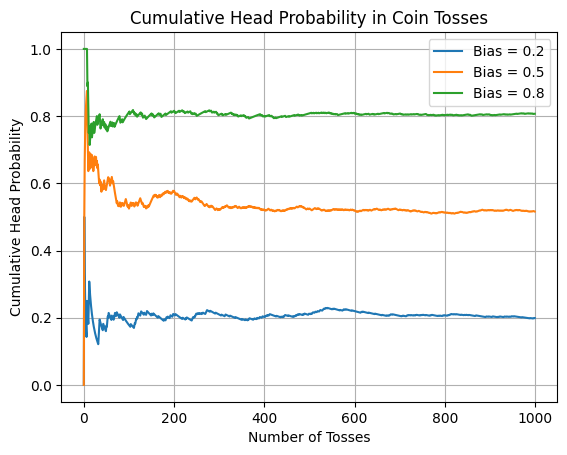

In [ ]:
np.random.seed(42)
num_tosses = 1000
coin_biases = [0.2, 0.5, 0.8]

def simulate_coin_toss(bias, num_tosses):
    return np.random.choice([0, 1], size=num_tosses, p=[1 - bias, bias])

for bias in coin_biases:
    tosses = simulate_coin_toss(bias, num_tosses)
    cumulative_heads = np.cumsum(tosses) / np.arange(1, num_tosses + 1)
    plt.plot(cumulative_heads, label=f'Bias = {bias}')

plt.title('Cumulative Head Probability in Coin Tosses')
plt.xlabel('Number of Tosses')
plt.ylabel('Cumulative Head Probability')
plt.legend()
plt.grid(True)
plt.show()

Now we shall try to estimate how the cumulative probability of getting a head shifts deviates significantly from the true bias. Here, we shall employ the Chernoff bound that calculates the probability of the cumulative head probability deviating significantly from the true bias.

In order to do this, we emply a function that calculates the Chernoff bound as below:

In [ ]:
def chernoff_bound(epsilon, N):
    return 2 * np.exp(-2 * N * epsilon**2)

Now we shall set our value of $\varepsilon$ which will serve as the error threshold. We plot a visualization to show how the Chernoff Inequality bounds (in blue) change as the number of coin tosses increases. The red dashed line represents the chosen error threshold $\varepsilon$, and we can observe how the bounds tighten with more data.

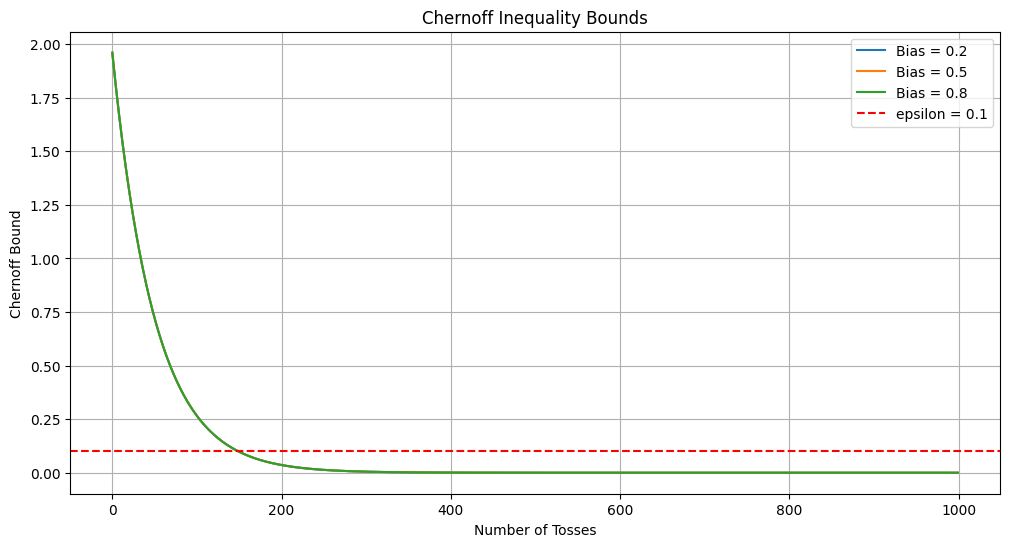

In [ ]:
epsilon = 0.1

# Visualize Chernoff bounds for different biases
plt.figure(figsize=(12, 6))

for bias in coin_biases:
    bounds = [chernoff_bound(epsilon, n) for n in range(1, num_tosses + 1)]
    plt.plot(bounds, label=f'Bias = {bias}')

plt.axhline(y=epsilon, color='r', linestyle='--', label=f'epsilon = {epsilon}')
plt.title('Chernoff Inequality Bounds')
plt.xlabel('Number of Tosses')
plt.ylabel('Chernoff Bound')
plt.legend()
plt.grid(True)
plt.show()

By applying the Chernoff bound to practical examples, such as simulating biased coin tosses, and using visualizations, we can gain a deeper understanding of how this inequality works and how it allows us to set confidence bounds on real-world data.

We shall see how the Chernoff bound how the Chernoff bound plays an important role in machine learning research in the subsequent section.

## Using The Chernoff Bound in Machine Learning

Suppose the task at hand is to build and understand a credit card fraud detection model. We shall deem that credit card fraud detection is a rare event and we want to be able to stop misclassifying such events using the Chernoff bound.

In order to do this, we shall generate our own dataset for this example, such that we have two classes: "Genuine" and "Fraudulent" transactions. In order to signify the rarity of fraudulent events, we shall grossly limit the representation of these events by just 5% of the total data.


In [ ]:
# Calling all imports

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Generate synthetic data
np.random.seed(42)

genuine_transactions = np.random.normal(250, 20, 950)
fraudulent_transactions = np.random.normal(250, 50, 50)



We will now create a label by assigning a ```0``` to the 950 real transactions and a ```1``` to the 50 fraudulent transactions. We then split the training and the testing data by using 20% of the data generated for verification and testing. We than use a Random Forest Classifier to train and classify our model. Then we evaluate our classification model use an accuracy metric.

In [ ]:
# Create labels
labels = [0] * 950 + [1] * 50

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.concatenate([genuine_transactions, fraudulent_transactions]), labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train.reshape(-1, 1), y_train)
y_pred = clf.predict(X_test.reshape(-1, 1))
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 94.50%


The model accuracy comes out to 94.5%. However, there is more than what meets the eye. In order to see this, we must first visualize the dataset that we have generated.

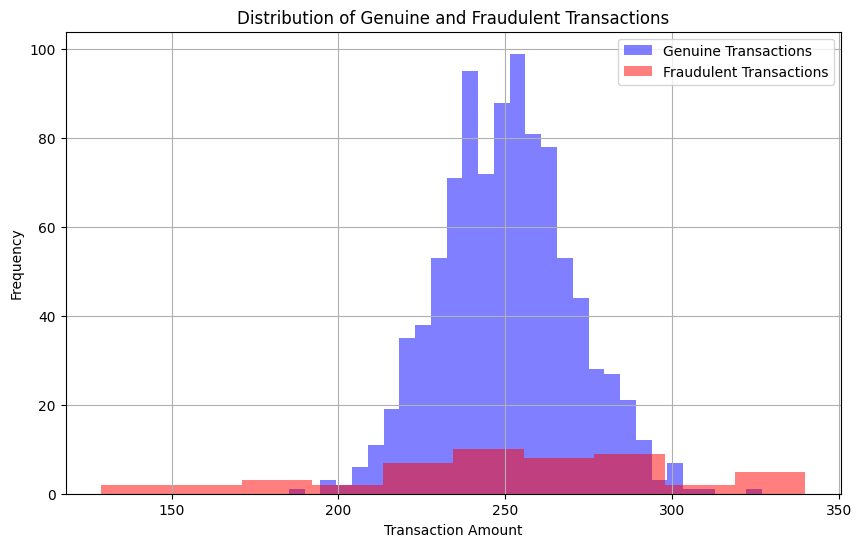

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(genuine_transactions, bins=30, alpha=0.5, label='Genuine Transactions', color='blue')
plt.hist(fraudulent_transactions, bins=10, alpha=0.5, label='Fraudulent Transactions', color='red')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Genuine and Fraudulent Transactions')
plt.legend()
plt.grid(True)
plt.show()

Now we shall apply the Chernoff bound to estimate the probability of our Random Forest Classifier misclassifying a fraudulent transaction as a genuine one.

In [ ]:
def chernoff_bound(epsilon, n):
    return np.exp(-n * epsilon**2 / 2)

epsilon = 0.05  # Desired error rate
n_fraudulent = len(fraudulent_transactions)
chernoff_probability = chernoff_bound(epsilon, n_fraudulent)

print(f"Chernoff Probability: {chernoff_probability:.2%}")

Chernoff Probability: 93.94%


The Chernoff probability i.e. the probability of datapoints being misclassified in our little experiment comes out to around **94%**, which should be alarming, despite what our model accuracy metric tells us.

In order to calculate how the Chernoff probability changes as sample size increases, we have the following piece of code:

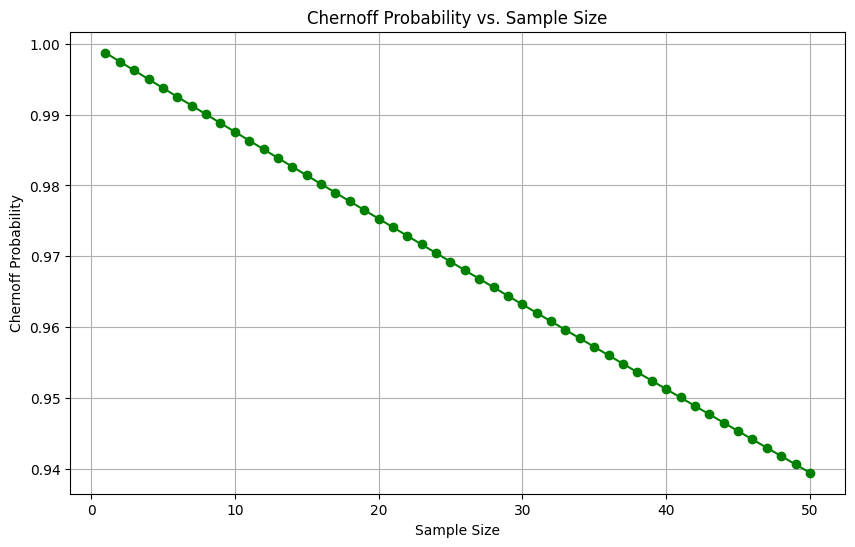

In [ ]:
sample_sizes = np.arange(1, len(fraudulent_transactions) + 1)
chernoff_probabilities = [chernoff_bound(epsilon, n) for n in sample_sizes]

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, chernoff_probabilities, marker='o', linestyle='-', color='green')
plt.xlabel('Sample Size')
plt.ylabel('Chernoff Probability')
plt.title('Chernoff Probability vs. Sample Size')
plt.grid(True)
plt.show()

Finally we plot how this model performs against a confusion matrix.

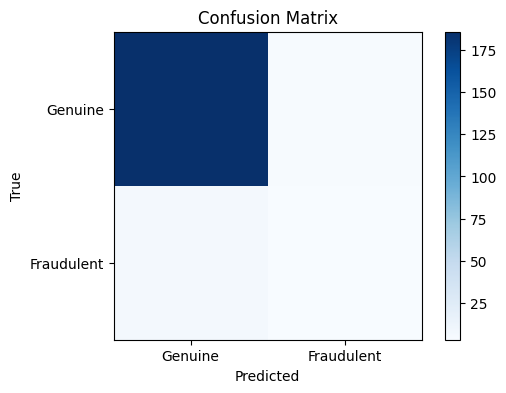

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Genuine', 'Fraudulent'])
plt.yticks([0, 1], labels=['Genuine', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In conclusion, we have seen how the performance metric does not give us an idea for the true performance of a classifier. The performance of this model can be better understood by the use of the Chernoff concentration bound. Through visualizations, we illustrated the data distribution, Chernoff probabilities, and model performance. Understanding and applying the Chernoff Inequality can help assess the reliability of machine learning models when dealing with rare events.